In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from bnn.ensembles_bnn import BAE_Ensemble_Manager
import pickle
import matplotlib.pyplot as plt
import numpy as np
from bnn.multiscaler import MultiScaler
import copy
from bnn.seed import bae_set_seed
from mpl_toolkits.mplot3d import Axes3D
import torch

In [10]:
#!git clone https://github.com/marooncn/Defect-Detection-Classifier.git

In [11]:
import os
import pandas as pd 
import glob

In [12]:
paths = "./Defect-Detection-Classifier/data/*"

category_paths = glob.glob(paths)

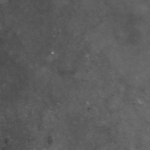

In [13]:
# load and show an image with Pillow
from PIL import Image
# load the image
path = "./Defect-Detection-Classifier/data/normal1/"
filename = "1.jpg"
max_size = (150,150)
image = Image.open(path + filename)
image = image.resize(max_size)
# summarize some details about the image

# show the image
image

In [14]:
image_list = []
dir_list = []
max_size = (175, 175)
for path in category_paths:
    for filename in glob.glob(path + "/*.jpg"): #assuming gif
        im=Image.open(filename)
        im = im.resize(max_size)
        image_list.append(im)
        dir_list.append(path)

In [15]:
dir_names = []
for d in dir_list:
    dn = d.split("/")[-1]
    dir_names.append(dn)

In [16]:
dir_names = pd.DataFrame(dir_names, columns=['dn'])

In [17]:
dir_names['defect'] = np.where(dir_names['dn'].str.contains('normal'), 0, 1)

In [18]:
from numpy import asarray
image_arrays = []
for im in image_list:
    ar = asarray(im)
    image_arrays.append(ar)
    

In [19]:
import numpy as np
image_arrays = np.array(image_arrays)
image_arrays.shape

(400, 175, 175)

In [20]:
image_arrays = image_arrays.reshape(len(image_arrays), image_arrays.shape[1]*image_arrays.shape[2])
image_arrays.shape

(400, 30625)

In [21]:
max_value = np.max(image_arrays)
image_arrays = image_arrays/max_value

In [22]:
#define model
optimiser = "Adam"
num_epoch_mu = 100 #10000 #1000
architecture_mu = [500,250,3,250,500]
architecture_sig_diag_cov=architecture_mu
lr = 0.0008
num_samples = 10
use_cuda = torch.cuda.is_available()

#diag_cov & combined mode
model_name = "diag_cov"
bae_model = BAE_Ensemble_Manager(architecture=architecture_mu, num_samples=num_samples,
                                 num_epoch=num_epoch_mu, learning_rate=lr, bottleneck_layer=2,
                                 task="regression", optimiser=optimiser, mode="diag_cov", use_cuda=use_cuda)

#fit model
bae_model.fit(image_arrays)


0LOG LOSS:2087.364990234375PW LOSS:-10520.30078125AE LOSS:12607.666015625
1LOG LOSS:1581.8060302734375PW LOSS:-10019.8974609375AE LOSS:11601.703125
2LOG LOSS:977.0311279296875PW LOSS:-9538.8046875AE LOSS:10515.8359375
3LOG LOSS:167.4109344482422PW LOSS:-9098.7470703125AE LOSS:9266.158203125
4LOG LOSS:-869.1272583007812PW LOSS:-8705.9150390625AE LOSS:7836.78759765625
5LOG LOSS:-2129.99462890625PW LOSS:-8357.578125AE LOSS:6227.58349609375
6LOG LOSS:-3581.34619140625PW LOSS:-8046.2392578125AE LOSS:4464.89306640625
7LOG LOSS:-5156.13427734375PW LOSS:-7761.6298828125AE LOSS:2605.49560546875
8LOG LOSS:-6772.275390625PW LOSS:-7492.87890625AE LOSS:720.603515625
9LOG LOSS:-8386.1962890625PW LOSS:-7234.26318359375AE LOSS:-1151.93310546875
10LOG LOSS:-10057.80078125PW LOSS:-6989.5849609375AE LOSS:-3068.2158203125
11LOG LOSS:-11958.7724609375PW LOSS:-6767.9248046875AE LOSS:-5190.84765625
12LOG LOSS:-14292.77734375PW LOSS:-6575.255859375AE LOSS:-7717.521484375
13LOG LOSS:-17196.66015625PW LOSS:-641

In [42]:
#predictions

#diag_cov & combined mode
model_name = "diag_cov"
result = bae_model.predict(image_arrays, mode=model_name)
result_mu = bae_model.predict(image_arrays, mode="mu")

In [43]:
def get_recon_signal(mode="noise",plot_sample_index = 1,plot_sensor_index =12,n_resample = 60,severity_index = 0):
    # feature_sensor_indices = range((n_resample*plot_sensor_index),(n_resample*(1+plot_sensor_index)))
    if mode == "noise":
        recon_sig=scaler.inverse_transform(result_noise[plot_sensor_index][severity_index]['y_pred'][0].reshape(-1,n_resample,total_sensors))
        recon_sig_epi_unc,recon_sig_alea_unc,recon_sig_total_unc=unc_scale(result_noise[plot_sensor_index][severity_index])
        ori_sig = scaler.inverse_transform(x_test_noise[plot_sensor_index][severity_index].reshape(-1,n_resample,total_sensors))
    elif mode=="drift":
        recon_sig=scaler.inverse_transform(result_drift[plot_sensor_index][severity_index]['y_pred'][0].reshape(-1,n_resample,total_sensors))
        recon_sig_epi_unc,recon_sig_alea_unc,recon_sig_total_unc=unc_scale(result_drift[plot_sensor_index][severity_index])
        ori_sig = scaler.inverse_transform(x_test_drift[plot_sensor_index][severity_index].reshape(-1,n_resample,total_sensors))
    else:
        recon_sig=scaler.inverse_transform(result_ood['y_pred'][0].reshape(-1,n_resample,total_sensors))
        recon_sig_epi_unc,recon_sig_alea_unc,recon_sig_total_unc=unc_scale(result_ood)
        ori_sig = scaler.inverse_transform(x_ood.reshape(-1,n_resample,total_sensors))

    recon_loss = ((recon_sig - ori_sig)**2)

    plot_recon_sig = recon_sig[plot_sample_index,:,plot_sensor_index]
    plot_ori_sig = ori_sig[plot_sample_index,:,plot_sensor_index]
    plot_recon_loss = recon_loss[plot_sample_index,:,plot_sensor_index]
    epi_unc =recon_sig_epi_unc[plot_sample_index,:,plot_sensor_index]
    alea_unc =recon_sig_alea_unc[plot_sample_index,:,plot_sensor_index]
    total_unc = recon_sig_total_unc[plot_sample_index,:,plot_sensor_index]

    return {"recon_sig":plot_recon_sig,
            "ori_sig":plot_ori_sig,
            "recon_loss":plot_recon_loss,
           "epi_unc":epi_unc,
           "alea_unc":alea_unc,
           "total_unc":total_unc
            }

In [44]:
#compute more accurate epistemic unc.
def unc_scale(result,seq_len=60,num_sens=17):
    raw_y_pred=result['raw'][0]
    scaled_raw_y_pred = []
    raw_y_cov=result['raw'][1]

    epi_result = raw_y_pred.std(0)
    alea_result = raw_y_cov.mean(0)
    total_unc = epi_result+alea_result
    return epi_result, alea_result,total_unc

In [53]:
epistemic, aleatoric, total = unc_scale(result)

aleatoric_pd = pd.DataFrame(aleatoric)
epistemic_pd = pd.DataFrame(epistemic)
a_sum = aleatoric_pd.sum(axis=1)
e_sum = epistemic_pd.sum(axis=1)

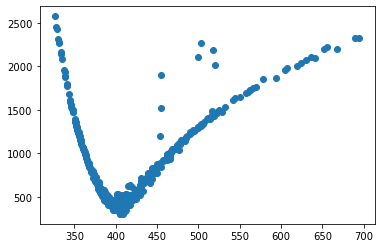

In [86]:
plt.scatter(a_sum, e_sum)

In [54]:
dir_names['a_sum'] = aleatoric_pd.sum(axis=1)
dir_names['e_sum'] = epistemic_pd.sum(axis=1)

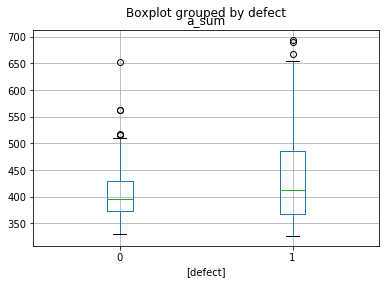

In [55]:
dir_names[['defect', 'a_sum']].boxplot(by='defect')

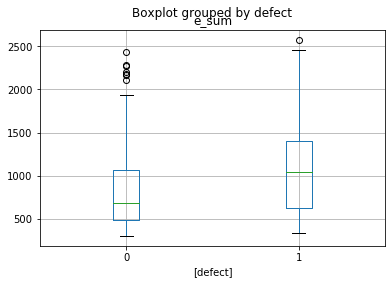

In [56]:
dir_names[['defect', 'e_sum']].boxplot(by='defect')

In [81]:
dir_names[dir_names['a_sum'] > 450]['defect'].value_counts()
dir_names[dir_names['a_sum'] > 450]['defect'].value_counts()


1    76
0    31
Name: defect, dtype: int64

In [82]:
 (76/(31+31))

1.2258064516129032

In [83]:
dir_names['e_boundary'] = np.where(dir_names['e_sum'] > 1500, 1, 0)

In [84]:
m0 = dir_names[dir_names['defect'] == 0]['a_sum']
m1 = dir_names[dir_names['defect'] == 1]['a_sum']

print('normal image mean is:' + str(m0.mean()))
print('defect image mean is:' + str(m1.mean()))
print(' ')

import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
tvalue, pvalue = stats.ttest_ind(m0 , m1, equal_var=False)
print(tvalue, pvalue)

normal image mean is:405.55725
defect image mean is:435.3672
 
-4.5059905285826405 9.267193781408113e-06


In [85]:
m0 = dir_names[dir_names['defect'] == 0]['e_sum']
m1 = dir_names[dir_names['defect'] == 1]['e_sum']


print('normal image mean is:' + str(m0.mean()))
print('defect image mean is:' + str(m1.mean()))
print(' ')

import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
tvalue, pvalue = stats.ttest_ind(m0 , m1, equal_var=False)
print(tvalue, pvalue)

normal image mean is:827.21344
defect image mean is:1086.1215
 
-5.284679879317123 2.095324632637823e-07


In [153]:
idx = dir_names[dir_names['e_sum'] == dir_names['e_sum'].max()].index
a = np.array(aleatoric[idx]).reshape(175,175)
e = np.array(epistemic[idx]).reshape(175,175)

In [154]:
idx

Int64Index([250], dtype='int64')

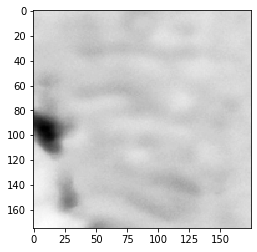

In [155]:
from matplotlib import pyplot
i = image_arrays[idx].reshape(175,175)
pyplot.imshow(i, cmap='Greys')

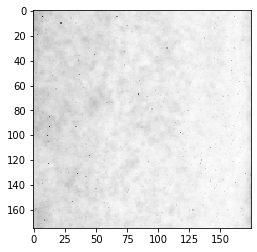

In [156]:
pyplot.imshow(a, cmap='Greys')

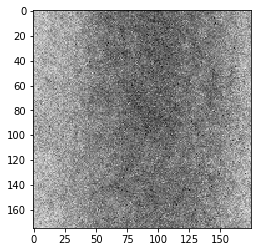

In [116]:
pyplot.imshow(e, cmap='Greys')

In [125]:
print(dir_names[dir_names['a_sum'] == dir_names['a_sum'].min()]['defect'].iloc[0])
idx = dir_names[dir_names['a_sum'] == dir_names['a_sum'].min()].index
a = np.array(aleatoric[idx]).reshape(175,175)
e = np.array(epistemic[idx]).reshape(175,175)

1


In [127]:
idx

Int64Index([250], dtype='int64')

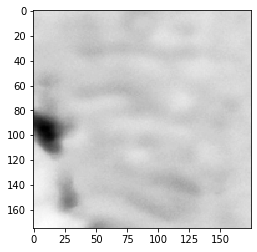

In [126]:
from matplotlib import pyplot
i = image_arrays[idx].reshape(175,175)
pyplot.imshow(i, cmap='Greys')

<hr>

In [140]:
dir_names[ (dir_names['a_sum'] > 600) & (dir_names['e_sum'] > 1200 )]

,dn,defect,a_sum,e_sum,e_boundary
41,defect5,1,654.931458,2222.884277,1
51,defect5,1,619.147705,2007.477173,1
63,defect5,1,635.607178,2106.832520,1
124,normal1,0,652.132080,2206.352295,1
253,defect2,1,605.157104,1957.961792,1
264,defect2,1,640.481445,2092.336426,1
281,defect4,1,607.128845,1977.469482,1
304,defect4,1,694.559326,2323.471436,1
338,defect1,1,630.151123,2073.811279,1
344,defect1,1,667.109375,2196.513184,1


In [148]:
idx = 41
a = np.array(aleatoric[idx]).reshape(175,175)
e = np.array(epistemic[idx]).reshape(175,175)

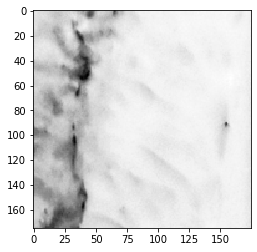

In [149]:
from matplotlib import pyplot
i = image_arrays[idx].reshape(175,175)
pyplot.imshow(i, cmap='Greys')

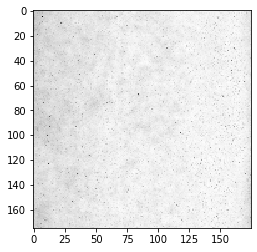

In [150]:
pyplot.imshow(a, cmap='Greys')

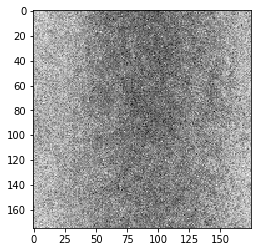

In [151]:
pyplot.imshow(e, cmap='Greys')

In [159]:
idx = 124
a = np.array(aleatoric[idx]).reshape(175,175)
e = np.array(epistemic[idx]).reshape(175,175)

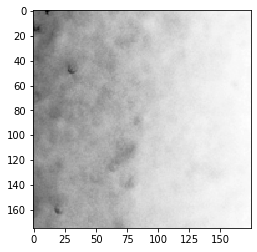

In [160]:
from matplotlib import pyplot
i = image_arrays[idx].reshape(175,175)
pyplot.imshow(i, cmap='Greys')